1) Proofs

In [1]:
#import statements
import pandas as pd
import numpy as np 
import math
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

2a) Computer Fourier Transform of the LnaNoise.png and center the low frequencies.

In [2]:
noisy_lena = np.asarray(Image.open("lenaNoise.png"))
f_transform = np.fft.fft2(noisy_lena)
centered_freqs = np.fft.fftshift(f_transform)
centered_freqs # shifted frequencies 

array([[ 29658.            +0.j        ,  29316.63163039+14477.69146795j,
        -48512.14731403-40811.57080227j, ...,
          1511.80146668+23127.64399522j, -48512.14731403+40811.57080227j,
         29316.63163039-14477.69146795j],
       [-43290.90814853-17202.23732646j, -52152.23577667-13174.37168505j,
         12078.23873321+24490.04590063j, ...,
        -11931.87392537 +9623.00604827j, -68413.90003696+35585.32460055j,
         29692.33311497 -3553.4446972j ],
       [-40758.05981   +54968.93354304j,  22887.32683276 -3611.19920119j,
        -48769.01445178+48446.91053499j, ...,
         35808.89438379-50946.35403436j, -29098.71790466+67625.36321637j,
         -8881.56102674 -7316.87425602j],
       ...,
       [ 14534.28564232-35598.01797021j,  38438.45103584-34823.94110166j,
          1331.05647101+17953.11721513j, ...,
        -60551.73665555+17009.13871371j,   9254.34591982+11319.50873641j,
         34048.85524244+38866.22782328j],
       [-40758.05981   -54968.93354304j,  -8

2b) Keep diff number of low freqs but set all other high frequencies to 0.

In [3]:
def set_frequencies(centered_freqs, sizes = [7, 15, 31, 512]):
    height, width =  centered_freqs.shape
    x_c = height//2 #x-center coord
    y_c = width//2 #y-center coord

    altered_freqs = []
    for size in sizes:
        temp = np.zeros_like(centered_freqs)
        extract = centered_freqs[x_c-(size//2):x_c+(size//2), y_c-(size//2):y_c+(size//2)]#slicing array from center
        temp[x_c-(size//2):x_c+(size//2), y_c-(size//2):y_c+(size//2)] = extract
        altered_freqs.append(temp)
    
    return altered_freqs

altered_freqs = set_frequencies(centered_freqs)


2c) Reconstruct orriginal image using new generated frequencies.

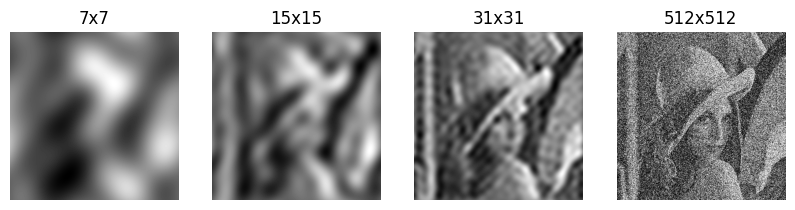

In [4]:
def reconstruct_images(unreconstructed_images, sizes = [7, 15, 31, 512]):    
    rows = 1
    cols = len(sizes)
    fig =  plt.figure(figsize = (10,7))
    reconstructed_images = [np.fft.ifft2(np.fft.ifftshift(ft)).real for ft in unreconstructed_images]
    for idx, img in enumerate(reconstructed_images):
        fig.add_subplot(rows,cols,idx+1)
        plt.imshow(img, cmap = 'gray')
        plt.title(f"{sizes[idx]}x{sizes[idx]}")
        plt.axis("off")


reconstruct_images(altered_freqs)

3a & 3b) Adding Gaussian noise at different variance & plotting

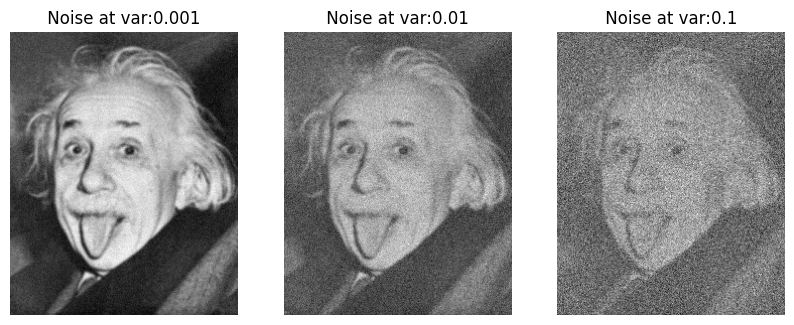

In [5]:
def rgb2gray(img):
    rgb_img = img[:,:,0]*0.229 + img[:,:,1]*0.587 + img[:,:,2]*0.114
    return rgb_img

def added_noise(gray_img, variances  = [0.001,0.01,0.1]):
    rows = 1
    columns = 3
    fig = plt.figure(figsize = (10,7))
    noisy_imgs = []
    for idx, var in enumerate(variances):
        gaussian_noise = np.random.normal(0,np.sqrt(var),gray_einstein.shape)
        noisy_img = gray_img+gaussian_noise
        noisy_imgs.append(noisy_img)
        fig.add_subplot(rows,columns,idx+1)
        plt.title(f" Noise at var:{var} ")
        plt.axis('off') 
        plt.imshow(noisy_img, cmap = 'gray')
    return noisy_imgs


einstein = np.asarray(Image.open("Einstein.jpeg"))
einstein = einstein/255.0 #normalization
gray_einstein = rgb2gray(einstein)
noisy_einsteins = added_noise(gray_einstein)



3c) Gradient Descent Algorithm for Denoising

In [27]:
# Estimates forward/backward differences
#Notes these were what worked for mme i also tried ndimage sobel filters but the denoised images came out in a grid like pattern
#helper functions
def Dx(u):
    grad_x = np.zeros_like(u)
    grad_x[:-1, :] = u[1:,:]- u[:-1, :]
    return grad_x

def Dy(u):
    grad_y = np.zeros_like(u)
    grad_y[:,:-1] = u[:,1:]- u[:, :-1]
    return grad_y

def forward_difference(u):
    grad_x = np.zeros_like(u)
    grad_x[1:, :] = u[1:,:] - u[:-1, :]
    return grad_x

def backward_difference(u):
    grad_y = np.zeros_like(u)
    grad_y[:,1:] = u[:, 1:] - u[:, :-1]
    return grad_y

def divergence(img):
    grad_x = Dx(img)
    grad_y = Dy(img)
    
    grad_magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2 + 1e-4)

    # # divergence of normalized gradient
    div_u = forward_difference(grad_x / grad_magnitude) + backward_difference(grad_y / grad_magnitude) + 1e-8

    # grad_x = ndimage.sobel(img, axis = 0, mode = "constant" )
    # grad_y = ndimage.sobel(img, axis = 1, mode = "constant")

    # grad_magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2 + 1e-4)

    # div_u = ndimage.sobel(grad_x / grad_magnitude, axis = 0 ) + ndimage.sobel(grad_y/grad_magnitude, axis = 0 )

    return div_u


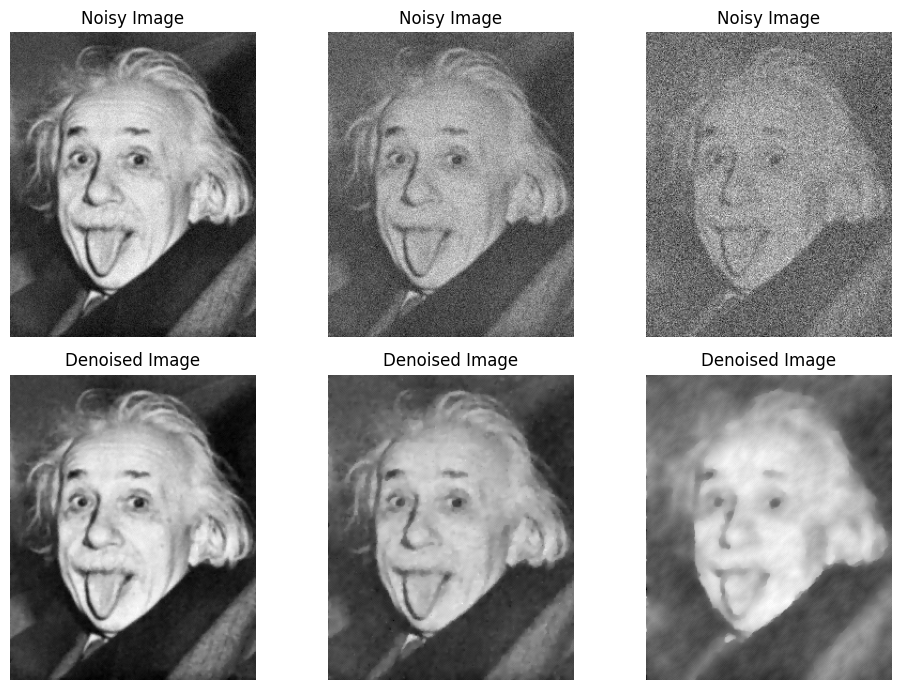

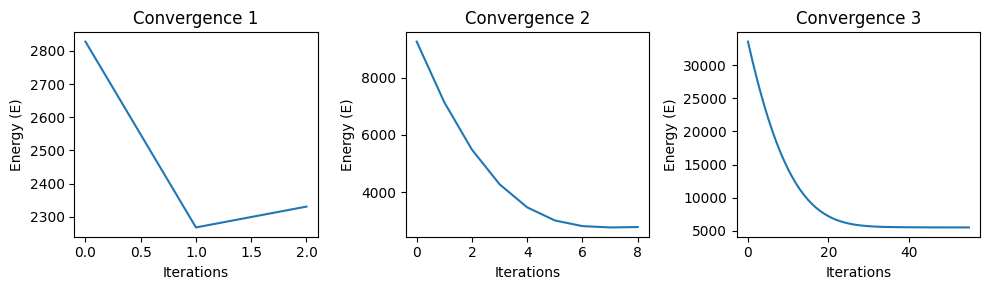

In [28]:
def compute_energy(u, f, reg_parameter):
    # lambda * the l2 norm of f & u 
    data_fidelity = reg_parameter * np.sum((f - u) ** 2)

    # # computing gradients 
    grad_x = Dx(u)
    grad_y = Dy(u)

    # grad_x = ndimage.sobel(u, axis = 0 )
    # grad_y = ndimage.sobel(u, axis = 1)
    # Total Variation
    total_variation = np.sum(np.sqrt(grad_x ** 2 + grad_y ** 2 + 1e-8))

    energy = data_fidelity + total_variation
    return energy

def grad_descent(noisy_img, tolerance=1e-8, lr=0.01, reg_parameter=0.5):
    MAX_ITERS = 10000
    f = noisy_img
    u = noisy_img
    E_values = []
    for iter in range(MAX_ITERS):
        # calculating energy function gradient
        grad_e = -2 * reg_parameter * (f - u) - divergence(u)

        # gradient descent, updating values
        u_new = u - lr * grad_e

        energy_diff = compute_energy(u, f, reg_parameter) - compute_energy(u_new, f, reg_parameter)
        E_values.append(compute_energy(u_new, f, reg_parameter))

        if energy_diff < tolerance:
            break

        u = u_new
        
    return u, E_values

def denoise_images(noisy_imgs):
    """Denoises a list of noisy images and returns denoised images and their energy values."""
    denoised_images = []
    e_values_list = []
    for img in noisy_imgs:
        denoised_img, e_values = grad_descent(img)
        denoised_images.append(denoised_img)
        e_values_list.append(e_values)
    return denoised_images, e_values_list

def plot_images(image_list, titles, rows, columns, cmap='gray', figsize=(10, 7)):
    """Plots a list of images in a grid with specified titles."""
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    for idx, ax in enumerate(axs.flat):
        ax.imshow(image_list[idx], cmap=cmap)
        ax.set_title(titles[idx])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def plot_energy_convergence(e_values_list):
    """Plots the convergence of energy values for denoising."""
    fig, axs = plt.subplots(1, len(e_values_list), figsize=(10, 3))
    for idx, ax in enumerate(axs.flat):
        ax.plot(e_values_list[idx])
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Energy (E)')
        ax.set_title(f'Convergence {idx + 1}')
    plt.tight_layout()
    plt.show()

def denoising(noisy_imgs):
    """Denoises images, then plots noisy, denoised images, and energy convergence."""
    denoised_images, e_values_list = denoise_images(noisy_imgs)
    
    # Plotting noisy and denoised images
    images_to_plot = noisy_imgs[:3] + denoised_images[:3]
    titles = ['Noisy Image'] * 3 + ['Denoised Image'] * 3
    plot_images(images_to_plot, titles, rows=2, columns=3)
    
    # Plotting energy convergence
    plot_energy_convergence(e_values_list[:3])

# Example run
denoising(noisy_einsteins) 